# Caffe VGG-CNN to Keras

In [1]:
from __future__ import division, print_function
from keras import backend as K
from keras.layers import Input
from keras.layers.core import Activation, Dense, Flatten
from keras.layers.convolutional import Convolution2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from IPython.core.display import display, HTML
from scipy.misc import imresize
import matplotlib.pyplot as plt
import numpy as np
import os
import re
%matplotlib inline

Using Theano backend.


## Caffe Model Layers

In [2]:
caffe_layer_names = [
    "data", 
    "conv1", "norm1", "pool1",
    "conv2", "pool2",
    "conv3",
    "conv4",
    "conv5", "pool5",
    "fc6",
    "fc7",
    "prob"
]
caffe_layer_shapes = {
    "data" : (10, 3, 224, 224),
    "conv1": (10, 96, 109, 109),
    "norm1": (10, 96, 109, 109),
    "pool1": (10, 96, 37, 37),
    "conv2": (10, 256, 33, 33),
    "pool2": (10, 256, 17, 17),
    "conv3": (10, 512, 17, 17),
    "conv4": (10, 512, 17, 17),
    "conv5": (10, 512, 17, 17),
    "pool5": (10, 512, 6, 6),
    "fc6"  : (10, 4096),
    "fc7"  : (10, 4096),
    "fc8"  : (10, 1000),
    "prob" : (10, 1000)
}

obuf = """
<table>
  <tr><th>layer.name</th><th>layer.output_shape</th></tr>
"""
for layer_name in caffe_layer_names:
    obuf += """
    <tr><td>{:s}</td><td>{:s}</td></tr>
    """.format(layer_name, caffe_layer_shapes[layer_name])
obuf += """</table>"""
display(HTML(obuf))

layer.name,layer.output_shape
data,"(10, 3, 224, 224)"
conv1,"(10, 96, 109, 109)"
norm1,"(10, 96, 109, 109)"
pool1,"(10, 96, 37, 37)"
conv2,"(10, 256, 33, 33)"
pool2,"(10, 256, 17, 17)"
conv3,"(10, 512, 17, 17)"
conv4,"(10, 512, 17, 17)"
conv5,"(10, 512, 17, 17)"
pool5,"(10, 512, 6, 6)"


### Set Theano dimension ordering

since the Caffe shape indicates that the ordering uses same dimension ordering as Theano.

In [3]:
K.set_image_dim_ordering("th")

### Rebuild network with Keras components

In [4]:
data = Input(shape=(3, 224, 224), name="DATA")

conv1 = Convolution2D(96, 7, 7, subsample=(2, 2))(data)
conv1 = Activation("relu", name="CONV1")(conv1)

norm1 = BatchNormalization(name="NORM1")(conv1)

pool1 = MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name="POOL1")(norm1)

conv2 = Convolution2D(256, 5, 5)(pool1)
conv2 = Activation("relu", name="CONV2")(conv2)

pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="POOL2")(conv2)

conv3 = Convolution2D(512, 3, 3)(pool2)
conv3 = Activation("relu", name="CONV3")(conv3)

conv4 = Convolution2D(512, 3, 3)(conv3)
conv4 = Activation("relu", name="CONV4")(conv4)

conv5 = Convolution2D(512, 3, 3)(conv4)
conv5 = Activation("relu", name="CONV5")(conv5)

pool5 = MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name="POOL5")(conv5)

fc6 = Flatten()(pool5)
fc6 = Dense(4096)(fc6)
fc6 = Activation("relu", name="FC6")(fc6)

fc7 = Dense(4096)(fc6)
fc7 = Activation("relu", name="FC7")(fc7)

fc8 = Dense(1000, name="FC8")(fc7)
prob = Activation("softmax", name="PROB")(fc8)

model = Model(input=[data], output=[prob])

model.compile(optimizer="adam", loss="categorical_crossentropy")

### Identify Shape Differences

In [5]:
def report_shape_differences(model, caffe_layer_shapes):
    obuf = """
    <table>
      <tr><th>layer.name</th><th>caffe.output_shape</th><th>keras.output_shape</th></tr>
    """
    for layer in model.layers:
        layer_name = layer.name
        if caffe_layer_shapes.has_key(layer_name.lower()):
            caffe_output_shape = str(caffe_layer_shapes[layer_name.lower()])
        else:
            caffe_output_shape = "-"
        keras_output_shape = re.sub("None", "10", str(layer.output_shape))
        bgcolor = "white"
        if caffe_output_shape != "-":
            if caffe_output_shape == keras_output_shape:
                bgcolor = "aquamarine"
            else:
                bgcolor = "pink"
        obuf += """
        <tr bgcolor="{:s}"><td>{:s}</td><td>{:s}</td><td>{:s}</td></tr>
        """.format(bgcolor, layer_name, caffe_output_shape, keras_output_shape)
    obuf += """</table>"""
    display(HTML(obuf))

report_shape_differences(model, caffe_layer_shapes)

layer.name,caffe.output_shape,keras.output_shape
DATA,"(10, 3, 224, 224)","(10, 3, 224, 224)"
convolution2d_1,-,"(10, 96, 109, 109)"
CONV1,"(10, 96, 109, 109)","(10, 96, 109, 109)"
NORM1,"(10, 96, 109, 109)","(10, 96, 109, 109)"
POOL1,"(10, 96, 37, 37)","(10, 96, 36, 36)"
convolution2d_2,-,"(10, 256, 32, 32)"
CONV2,"(10, 256, 33, 33)","(10, 256, 32, 32)"
POOL2,"(10, 256, 17, 17)","(10, 256, 16, 16)"
convolution2d_3,-,"(10, 512, 14, 14)"
CONV3,"(10, 512, 17, 17)","(10, 512, 14, 14)"


### Changes

* Add (0, 2, 0, 2) zero padding before POOL1
* Add (0, 1, 0, 1) zero padding before POOL2
* Add (0, 2, 0, 2) zero padding before CONV3
* Add (0, 2, 0, 2) zero padding before CONV4
* Add (0, 2, 0, 2) zero padding before CONV5
* Add (0, 1, 0, 1) zero padding before POOL5

In [6]:
data = Input(shape=(3, 224, 224), name="DATA")

conv1 = Convolution2D(96, 7, 7, subsample=(2, 2))(data)
conv1 = Activation("relu", name="CONV1")(conv1)

norm1 = BatchNormalization(name="NORM1")(conv1)

pool1 = ZeroPadding2D(padding=(0, 2, 0, 2))(norm1)
pool1 = MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name="POOL1")(pool1)

conv2 = Convolution2D(256, 5, 5)(pool1)
conv2 = Activation("relu", name="CONV2")(conv2)

pool2 = ZeroPadding2D(padding=(0, 1, 0, 1))(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="POOL2")(pool2)

conv3 = ZeroPadding2D(padding=(0, 2, 0, 2))(pool2)
conv3 = Convolution2D(512, 3, 3)(conv3)
conv3 = Activation("relu", name="CONV3")(conv3)

conv4 = ZeroPadding2D(padding=(0, 2, 0, 2))(conv3)
conv4 = Convolution2D(512, 3, 3)(conv4)
conv4 = Activation("relu", name="CONV4")(conv4)

conv5 = ZeroPadding2D(padding=(0, 2, 0, 2))(conv4)
conv5 = Convolution2D(512, 3, 3)(conv5)
conv5 = Activation("relu", name="CONV5")(conv5)

pool5 = ZeroPadding2D(padding=(0, 1, 0, 1))(conv5)
pool5 = MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name="POOL5")(pool5)

fc6 = Flatten()(pool5)
fc6 = Dense(4096)(fc6)
fc6 = Activation("relu", name="FC6")(fc6)

fc7 = Dense(4096)(fc6)
fc7 = Activation("relu", name="FC7")(fc7)

fc8 = Dense(1000, name="FC8")(fc7)
prob = Activation("softmax", name="PROB")(fc8)

model = Model(input=[data], output=[prob])

model.compile(optimizer="adam", loss="categorical_crossentropy")

## Check differences

In [7]:
report_shape_differences(model, caffe_layer_shapes)

layer.name,caffe.output_shape,keras.output_shape
DATA,"(10, 3, 224, 224)","(10, 3, 224, 224)"
convolution2d_6,-,"(10, 96, 109, 109)"
CONV1,"(10, 96, 109, 109)","(10, 96, 109, 109)"
NORM1,"(10, 96, 109, 109)","(10, 96, 109, 109)"
zeropadding2d_1,-,"(10, 96, 111, 111)"
POOL1,"(10, 96, 37, 37)","(10, 96, 37, 37)"
convolution2d_7,-,"(10, 256, 33, 33)"
CONV2,"(10, 256, 33, 33)","(10, 256, 33, 33)"
zeropadding2d_2,-,"(10, 256, 34, 34)"
POOL2,"(10, 256, 17, 17)","(10, 256, 17, 17)"


### Replace Batch Normalization with Local Response Normalization

Snippet from protobuf file from Caffe model shown below:

    24 layers {
    25   bottom: "conv1"
    26   top: "norm1"
    27   name: "norm1"
    28   type: LRN
    29   lrn_param {
    30     local_size: 5
    31     alpha: 0.0005
    32     beta: 0.75
    33     k: 2
    34   }
    35 }

Equation:

<a href="https://www.codecogs.com/eqnedit.php?latex=LRN(x_{f,r,c})&space;=&space;\frac{x_{f,r,c}}{\left&space;(&space;k&space;&plus;&space;\alpha&space;\sum_{i=f-\frac{n}{2}}^{f&plus;\frac{n}{2}}&space;x_{i,r,c}^{2}\right&space;)^{\beta}}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?LRN(x_{f,r,c})&space;=&space;\frac{x_{f,r,c}}{\left&space;(&space;k&space;&plus;&space;\alpha&space;\sum_{i=f-\frac{n}{2}}^{f&plus;\frac{n}{2}}&space;x_{i,r,c}^{2}\right&space;)^{\beta}}" title="LRN(x_{f,r,c}) = \frac{x_{f,r,c}}{\left ( k + \alpha \sum_{i=f-\frac{n}{2}}^{f+\frac{n}{2}} x_{i,r,c}^{2}\right )^{\beta}}" /></a>

We cheat a little here, since this is not possible to run this without specifying a batch size in tensorflow. This was originally available in Keras using the Theano backend and then removed because (a) it is not possible to implement this without specifying the batch size per Francois Chollet's comment on this [Keras issue](https://github.com/fchollet/keras/issues/1549) and (b) LRN is no longer considered very useful because better methods such as Batch normalization have been invented since, according to this [Cross Validated discussion](http://stats.stackexchange.com/questions/145768/importance-of-local-response-normalization-in-cnn).

Since we are trying to recreate a Caffe model in Keras, our layer is very special purpose and we feel okay about putting in this batch size dependency (since batch sizes are pre-specified for Caffe models).

In [8]:
from keras import backend as K
from keras.engine.topology import Layer, InputSpec

class LocalResponseNormalization(Layer):
    
    def __init__(self, n=5, alpha=0.0005, beta=0.75, k=2, **kwargs):
        self.n = n
        self.alpha = alpha
        self.beta = beta
        self.k = k
        super(LocalResponseNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.shape = input_shape
        super(LocalResponseNormalization, self).build(input_shape)

    def call(self, x, mask=None):
        if K.image_dim_ordering == "th":
            _, f, r, c = self.shape
        else:
            _, r, c, f = self.shape
        half_n = self.n // 2
        squared = K.square(x)
        pooled = K.pool2d(squared, (half_n, half_n), strides=(1, 1),
                         border_mode="same", pool_mode="avg")
        if K.image_dim_ordering == "th":
            summed = K.sum(pooled, axis=1, keepdims=True)
            averaged = (self.alpha / self.n) * K.repeat_elements(summed, f, axis=1)
        else:
            summed = K.sum(pooled, axis=3, keepdims=True)
            averaged = (self.alpha / self.n) * K.repeat_elements(summed, f, axis=3)
        denom = K.pow(self.k + averaged, self.beta)
        return x / denom
    
    def get_output_shape_for(self, input_shape):
        return input_shape


### Stick the layer into the network definition

Network definition copy-pasted from cell above after output shapes match across all layers.

In [9]:
data = Input(shape=(3, 224, 224), name="DATA")

conv1 = Convolution2D(96, 7, 7, subsample=(2, 2))(data)
conv1 = Activation("relu", name="CONV1")(conv1)

norm1 = LocalResponseNormalization(name="NORM1")(conv1)

pool1 = ZeroPadding2D(padding=(0, 2, 0, 2))(norm1)
pool1 = MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name="POOL1")(pool1)

conv2 = Convolution2D(256, 5, 5)(pool1)
conv2 = Activation("relu", name="CONV2")(conv2)

pool2 = ZeroPadding2D(padding=(0, 1, 0, 1))(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="POOL2")(pool2)

conv3 = ZeroPadding2D(padding=(0, 2, 0, 2))(pool2)
conv3 = Convolution2D(512, 3, 3)(conv3)
conv3 = Activation("relu", name="CONV3")(conv3)

conv4 = ZeroPadding2D(padding=(0, 2, 0, 2))(conv3)
conv4 = Convolution2D(512, 3, 3)(conv4)
conv4 = Activation("relu", name="CONV4")(conv4)

conv5 = ZeroPadding2D(padding=(0, 2, 0, 2))(conv4)
conv5 = Convolution2D(512, 3, 3)(conv5)
conv5 = Activation("relu", name="CONV5")(conv5)

pool5 = ZeroPadding2D(padding=(0, 1, 0, 1))(conv5)
pool5 = MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name="POOL5")(pool5)

fc6 = Flatten()(pool5)
fc6 = Dense(4096)(fc6)
fc6 = Activation("relu", name="FC6")(fc6)

fc7 = Dense(4096)(fc6)
fc7 = Activation("relu", name="FC7")(fc7)

fc8 = Dense(1000, name="FC8")(fc7)
prob = Activation("softmax", name="PROB")(fc8)

model = Model(input=[data], output=[prob])

model.compile(optimizer="adam", loss="categorical_crossentropy")

### Add the weights

Transformations in line with Caffe's correlation vs Keras's convolution. Refer to [memo about convolution in Caffe](https://github.com/Yangqing/caffe/wiki/Convolution-in-Caffe:-a-memo) for details.

In [10]:
def transform_conv_weight(W):
    # for non FC layers, do this because Keras does convolution vs Caffe correlation
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i, j] = np.rot90(W[i, j], 2)
    return W

def transform_fc_weight(W):
    return W.T

CAFFE_WEIGHTS_DIR = "/Users/palsujit/Projects/fttl-with-keras/data/vgg-cnn/saved-weights"

W_conv1 = transform_conv_weight(np.load(os.path.join(CAFFE_WEIGHTS_DIR, "W_conv1.npy")))
b_conv1 = np.load(os.path.join(CAFFE_WEIGHTS_DIR, "b_conv1.npy"))

W_conv2 = transform_conv_weight(np.load(os.path.join(CAFFE_WEIGHTS_DIR, "W_conv2.npy")))
b_conv2 = np.load(os.path.join(CAFFE_WEIGHTS_DIR, "b_conv2.npy"))

W_conv3 = transform_conv_weight(np.load(os.path.join(CAFFE_WEIGHTS_DIR, "W_conv3.npy")))
b_conv3 = np.load(os.path.join(CAFFE_WEIGHTS_DIR, "b_conv3.npy"))

W_conv4 = transform_conv_weight(np.load(os.path.join(CAFFE_WEIGHTS_DIR, "W_conv4.npy")))
b_conv4 = np.load(os.path.join(CAFFE_WEIGHTS_DIR, "b_conv4.npy"))

W_conv5 = transform_conv_weight(np.load(os.path.join(CAFFE_WEIGHTS_DIR, "W_conv5.npy")))
b_conv5 = np.load(os.path.join(CAFFE_WEIGHTS_DIR, "b_conv5.npy"))

W_fc6 = transform_fc_weight(np.load(os.path.join(CAFFE_WEIGHTS_DIR, "W_fc6.npy")))
b_fc6 = np.load(os.path.join(CAFFE_WEIGHTS_DIR, "b_fc6.npy"))

W_fc7 = transform_fc_weight(np.load(os.path.join(CAFFE_WEIGHTS_DIR, "W_fc7.npy")))
b_fc7 = np.load(os.path.join(CAFFE_WEIGHTS_DIR, "b_fc7.npy"))

W_fc8 = transform_fc_weight(np.load(os.path.join(CAFFE_WEIGHTS_DIR, "W_fc8.npy")))
b_fc8 = np.load(os.path.join(CAFFE_WEIGHTS_DIR, "b_fc8.npy"))

In [11]:
data = Input(shape=(3, 224, 224), name="DATA")

conv1 = Convolution2D(96, 7, 7, subsample=(2, 2),
                     weights=(W_conv1, b_conv1))(data)
conv1 = Activation("relu", name="CONV1")(conv1)

norm1 = LocalResponseNormalization(name="NORM1")(conv1)

pool1 = ZeroPadding2D(padding=(0, 2, 0, 2))(norm1)
pool1 = MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name="POOL1")(pool1)

conv2 = Convolution2D(256, 5, 5, weights=(W_conv2, b_conv2))(pool1)
conv2 = Activation("relu", name="CONV2")(conv2)

pool2 = ZeroPadding2D(padding=(0, 1, 0, 1))(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="POOL2")(pool2)

conv3 = ZeroPadding2D(padding=(0, 2, 0, 2))(pool2)
conv3 = Convolution2D(512, 3, 3, weights=(W_conv3, b_conv3))(conv3)
conv3 = Activation("relu", name="CONV3")(conv3)

conv4 = ZeroPadding2D(padding=(0, 2, 0, 2))(conv3)
conv4 = Convolution2D(512, 3, 3, weights=(W_conv4, b_conv4))(conv4)
conv4 = Activation("relu", name="CONV4")(conv4)

conv5 = ZeroPadding2D(padding=(0, 2, 0, 2))(conv4)
conv5 = Convolution2D(512, 3, 3, weights=(W_conv5, b_conv5))(conv5)
conv5 = Activation("relu", name="CONV5")(conv5)

pool5 = ZeroPadding2D(padding=(0, 1, 0, 1))(conv5)
pool5 = MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name="POOL5")(pool5)

fc6 = Flatten()(pool5)
fc6 = Dense(4096, weights=(W_fc6, b_fc6))(fc6)
fc6 = Activation("relu", name="FC6")(fc6)

fc7 = Dense(4096, weights=(W_fc7, b_fc7))(fc6)
fc7 = Activation("relu", name="FC7")(fc7)

fc8 = Dense(1000, weights=(W_fc8, b_fc8), name="FC8")(fc7)
prob = Activation("softmax", name="PROB")(fc8)

model = Model(input=[data], output=[prob])

model.compile(optimizer="adam", loss="categorical_crossentropy")

In [12]:
report_shape_differences(model, caffe_layer_shapes)

layer.name,caffe.output_shape,keras.output_shape
DATA,"(10, 3, 224, 224)","(10, 3, 224, 224)"
convolution2d_16,-,"(10, 96, 109, 109)"
CONV1,"(10, 96, 109, 109)","(10, 96, 109, 109)"
NORM1,"(10, 96, 109, 109)","(10, 96, 109, 109)"
zeropadding2d_13,-,"(10, 96, 111, 111)"
POOL1,"(10, 96, 37, 37)","(10, 96, 37, 37)"
convolution2d_17,-,"(10, 256, 33, 33)"
CONV2,"(10, 256, 33, 33)","(10, 256, 33, 33)"
zeropadding2d_14,-,"(10, 256, 34, 34)"
POOL2,"(10, 256, 17, 17)","(10, 256, 17, 17)"


### Prediction

[Check your predictions](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) here.


In [13]:
id2label = {}
flabel = open("../data/caffe2keras-labels.txt", "rb")
for line in flabel:
    lid, lname = line.strip().split("\t")
    id2label[int(lid)] = lname
flabel.close()

(360, 480, 3) (1, 3, 224, 224) (1, 3, 224, 224)


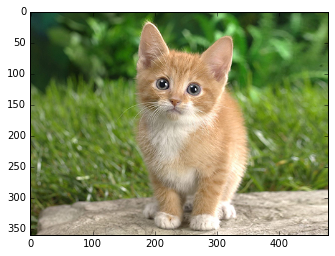

In [14]:
def preprocess_image(img, resize_wh, mean_image):
    # resize
    img4d = imresize(img, (resize_wh, resize_wh))
    img4d = img4d.astype("float32")
    # BGR -> RGB
    img4d = img4d[:, :, ::-1]
    # swap axes to theano mode
    img4d = np.transpose(img4d, (2, 0, 1))
    # add batch dimension
    img4d = np.expand_dims(img4d, axis=0)
    # subtract mean image
    img4d -= mean_image
    # clip to uint
    img4d = np.clip(img4d, 0, 255).astype("uint8")
    return img4d
    
CAT_IMAGE = "/Users/palsujit/Projects/fttl-with-keras/data/vgg-cnn/cat.jpg"
RESIZE_WH = 224
MEAN_IMAGE = "/Users/palsujit/Projects/fttl-with-keras/data/vgg-cnn/mean_image.npy"

mean_image = np.load(MEAN_IMAGE)
image = plt.imread(CAT_IMAGE)
img4d = preprocess_image(image, RESIZE_WH, mean_image)

print(image.shape, mean_image.shape, img4d.shape)
plt.imshow(image)

In [15]:
preds = model.predict(img4d)[0]

In [16]:
# tabby cat: expect 281
np.argmax(preds)

281

In [17]:
top_preds = np.argsort(preds)[::-1][0:10]
top_preds

array([281, 285, 282, 277, 287, 284, 283, 263, 387, 892])

In [18]:
pred_probas = [(x, id2label[x], preds[x]) for x in top_preds]
pred_probas

[(281, 'tabby, tabby cat', 0.091636732),
 (285, 'Egyptian cat', 0.060721621),
 (282, 'tiger cat', 0.038346913),
 (277, 'red fox, Vulpes vulpes', 0.028440412),
 (287, 'lynx, catamount', 0.020138463),
 (284, 'Siamese cat, Siamese', 0.015518123),
 (283, 'Persian cat', 0.012380695),
 (263, 'Pembroke, Pembroke Welsh corgi', 0.012343671),
 (387,
  'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
  0.01201651),
 (892, 'wall clock', 0.012008683)]

## References

* http://joelouismarino.github.io/blog_posts/blog_googlenet_keras.html
* https://keunwoochoi.wordpress.com/2016/11/18/for-beginners-writing-a-custom-keras-layer/
* http://shashankg7.github.io/2016/10/12/Custom-Layer-In-Keras-Graph-Embedding-Case-Study.html
* https://keras.io/backend/
* https://keras.io/layers/writing-your-own-keras-layers/
* https://github.com/MarcBS/keras/blob/master/keras/caffe/convert.py
* http://nbviewer.jupyter.org/github/BVLC/caffe/blob/master/examples/00-classification.ipynb